In [1]:
!wget https://github.com/ageron/data/raw/main/ridership.tgz

--2025-04-28 11:33:55--  https://github.com/ageron/data/raw/main/ridership.tgz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/data/main/ridership.tgz [following]
--2025-04-28 11:33:56--  https://raw.githubusercontent.com/ageron/data/main/ridership.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 108512 (106K) [application/octet-stream]
Saving to: ‘ridership.tgz’

ridership.tgz       100%[===================>] 105.97K  --.-KB/s    in 0.004s  

2025-04-28 11:33:56 (25.6 MB/s) - ‘ridership.tgz’ saved [108512/108512]



In [2]:
!tar -xf ridership.tgz

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import math

# Data preparation

In [4]:
df = pd.read_csv("ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv", parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"] # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) # no need for total, it's just bus + rail
df = df.drop_duplicates() # remove duplicated months (2011-10 and 2014-07)

In [5]:
df

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917
...,...,...,...
2021-11-26,W,257700,189694
2021-11-27,A,237839,187065
2021-11-28,U,184817,147830


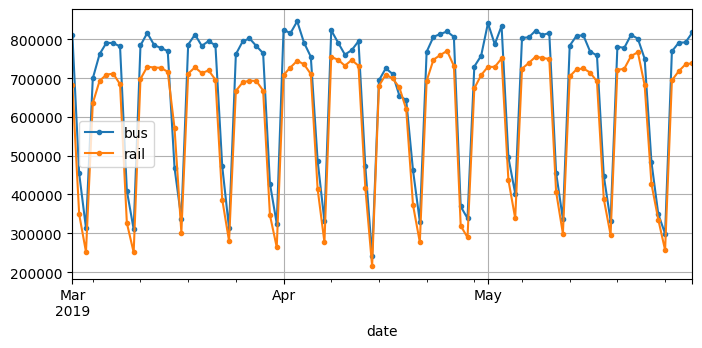

In [6]:
import matplotlib.pyplot as plt
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

In [7]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [8]:
# Function to create sequences
def create_sequences(data, seq_length=56):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(rail_train.values)
X_valid, y_valid = create_sequences(rail_valid.values)
X_test, y_test = create_sequences(rail_test.values)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [9]:
# Reshape for RNN, GRU, Transformer (batch, seq_len, features)
X_train_rnn = X_train_tensor.unsqueeze(-1)
X_valid_rnn = X_valid_tensor.unsqueeze(-1)
X_test_rnn = X_test_tensor.unsqueeze(-1)

# For MLP, keep it as (batch, seq_len)
X_train_mlp = X_train_tensor
X_valid_mlp = X_valid_tensor
X_test_mlp = X_test_tensor


## **Models building**

In [10]:
class MLP(nn.Module):
    def __init__(self, input_size=56, hidden_size1=128, hidden_size2=64):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

In [11]:
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take the last time step
        out = self.fc(out)
        return out

In [12]:
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [13]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return x

class TransformerEncoderModel(nn.Module):
    def __init__(self, input_size=1, d_model=64, nhead=4, dim_feedforward=128, num_layers=1):
        super(TransformerEncoderModel, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc1 = nn.Linear(d_model, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)  # Average over sequence length
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [14]:
from tqdm import tqdm

def train_model(model, train_loader, valid_loader, epochs=50):
    criterion = nn.MSELoss()
    optimizer = optim.NAdam(model.parameters())
    train_losses = []
    valid_losses = []

    pbar = tqdm(total=epochs, desc=f"Training")
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                output = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                valid_loss += loss.item() * X_batch.size(0)
        valid_loss /= len(valid_loader.dataset)
        valid_losses.append(valid_loss)

        pbar.set_postfix({"Train Loss": f"{train_loss:.6f}", "Valid Loss": f"{valid_loss:.6f}"})
        pbar.update(1)
    pbar.close()

    return model, train_losses, valid_losses

# Evaluation Function
def evaluate_model(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        eval_pbar = tqdm(test_loader, desc="Evaluating")
        for X_batch, y_batch in eval_pbar:
            output = model(X_batch)
            y_pred.extend(output.squeeze().tolist())
            y_true.extend(y_batch.tolist())

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    return mse, rmse, mae

# Initialize and Train Models
models = {
    "MLP": MLP(),
    "RNN": RNN(),
    "GRU": GRU(),
    "Transformer": TransformerEncoderModel()
}

# DataLoaders for MLP
train_dataset_mlp = TensorDataset(X_train_mlp, y_train_tensor)
valid_dataset_mlp = TensorDataset(X_valid_mlp, y_valid_tensor)
test_dataset_mlp = TensorDataset(X_test_mlp, y_test_tensor)
train_loader_mlp = DataLoader(train_dataset_mlp, batch_size=16, shuffle=True)
valid_loader_mlp = DataLoader(valid_dataset_mlp, batch_size=16, shuffle=False)
test_loader_mlp = DataLoader(test_dataset_mlp, batch_size=16, shuffle=False)

# DataLoaders for RNN, GRU, Transformer
train_dataset_rnn = TensorDataset(X_train_rnn, y_train_tensor)
valid_dataset_rnn = TensorDataset(X_valid_rnn, y_valid_tensor)
test_dataset_rnn = TensorDataset(X_test_rnn, y_test_tensor)
train_loader_rnn = DataLoader(train_dataset_rnn, batch_size=16, shuffle=True)
valid_loader_rnn = DataLoader(valid_dataset_rnn, batch_size=16, shuffle=False)
test_loader_rnn = DataLoader(test_dataset_rnn, batch_size=16, shuffle=False)

# Train and Evaluate Models
results = []
train_histories = {}

model_pbar = tqdm(models.items(), desc="Models", total=len(models))
for name, model in model_pbar:
    model_pbar.set_description(f"Training {name}")
    if name == "MLP":
        model, train_losses, valid_losses = train_model(model, train_loader_mlp, valid_loader_mlp)
        mse, rmse, mae = evaluate_model(model, test_loader_mlp)
    else:
        model, train_losses, valid_losses = train_model(model, train_loader_rnn, valid_loader_rnn)
        mse, rmse, mae = evaluate_model(model, test_loader_rnn)

    train_histories[name] = (train_losses, valid_losses)
    results.append({"Model": name, "MSE": mse, "RMSE": rmse, "MAE": mae})

# Results Table
results_df = pd.DataFrame(results)
print("\nResults Table:")
print(results_df)



Training: 100%|██████████| 50/50 [00:10<00:00,  4.98it/s, Train Loss=0.004423, Valid Loss=0.003996]

Training: 100%|██████████| 50/50 [00:55<00:00,  1.12s/it, Train Loss=0.005091, Valid Loss=0.003935]

Training: 100%|██████████| 50/50 [02:29<00:00,  2.98s/it, Train Loss=0.004698, Valid Loss=0.003507]

Training: 100%|██████████| 50/50 [00:57<00:00,  1.14s/it, Train Loss=0.003049, Valid Loss=0.005699]

Training Transformer: 100%|██████████| 4/4 [04:43<00:00, 70.88s/it]


Results Table:
         Model       MSE      RMSE       MAE
0          MLP  0.016146  0.127068  0.112642
1          RNN  0.011670  0.108026  0.090531
2          GRU  0.013370  0.115629  0.095464
3  Transformer  0.010984  0.104803  0.072438


Plotting MLP:   0%|          | 0/4 [00:00<?, ?it/s]

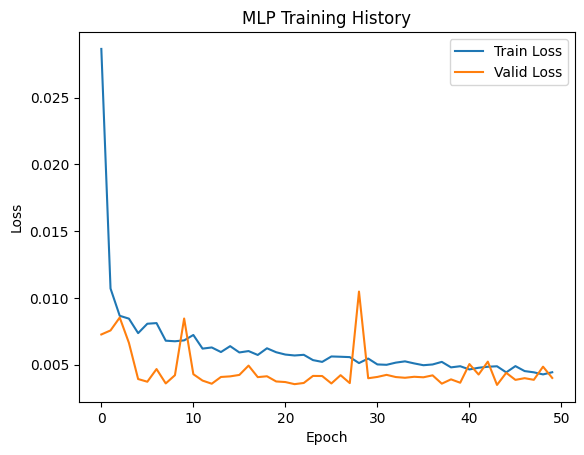

Plotting RNN:  25%|██▌       | 1/4 [00:00<00:00,  3.85it/s]

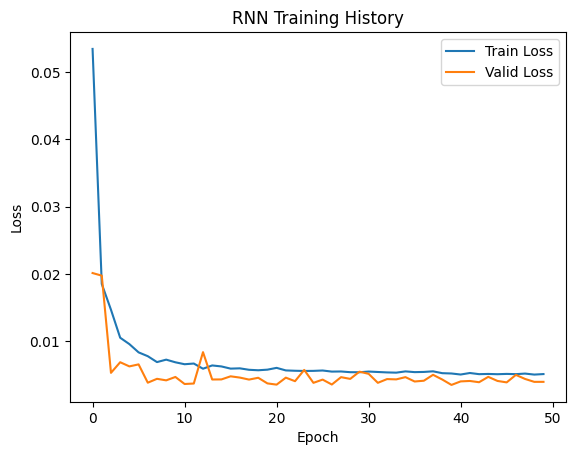

Plotting GRU:  50%|█████     | 2/4 [00:00<00:00,  4.25it/s]

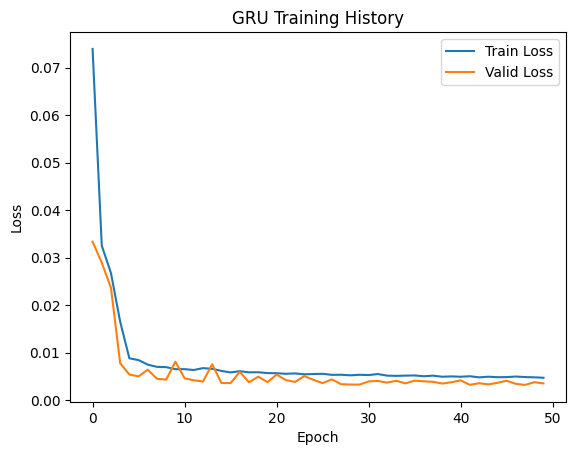

Plotting Transformer:  75%|███████▌  | 3/4 [00:00<00:00,  4.19it/s]

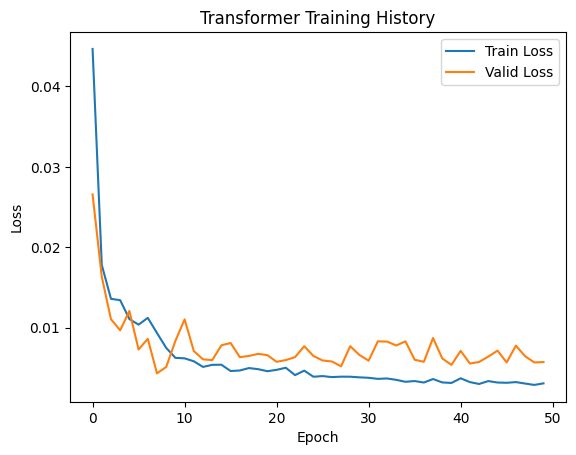

Plotting Transformer: 100%|██████████| 4/4 [00:01<00:00,  3.53it/s]


In [15]:
# Plot Training Histories
plot_pbar = tqdm(train_histories.items(), desc="Plotting", total=len(train_histories))
for name, (train_losses, valid_losses) in plot_pbar:
    plot_pbar.set_description(f"Plotting {name}")
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Valid Loss")
    plt.title(f"{name} Training History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f"{name}_training_history.png")
    plt.show()